### Machine Learning For Everyone and Robot
[Lecture notes](https://github.com/idebtor/HuStar-ML) for HuStar Project by idebtor@gmail.com, Handong Global University
**************

# 제 11 강: Gradient Descent 3 - Mini-Batch

## 학습목표 
- 경사하강법$^{gradient \ descent}$ 학습의 정확도를 이해한다.
- 배치$^{batch}$, 확률적$^{stochastic}$, 미니배치$^{mini-batch}$ 경사하강법들의 차이를 이해한다.
- 다양한 기계 학습 기술을 익힌다. 

## 학습 내용
- 다양한 경사하강법들의 장단점 비교하기
- 배치$^{batch}$, 미니배치$^{mini-batch}$ 경사하강법$^{gradient descent}$의 정확도 이해하기 
- 과적합$^{overfitting}$ 원인과 해결 방법
- 학습 조기 종료$^{early \ stopping}$
- 데이터 증식
- 드롭아웃$^{dropout}$

## MNIST 미니배치 경사하강법 신경망의 구현

우리는 앞 강의에서 MNIST 데이터셋의 분류 문제를 다룰 수 있는 신경망에 대해 공부습니다.  이번에는 경사하강법을 좀 더 효율적으로 할 수 있는 확률적 경사하강법에 대해 알아 보겠습니다. 

## 1. 미니배치$^{mini-batch}$

확률적 경사하강법은 자료를 하나씩 처리합니다. 미니배치 경사하강법은 자료를 하나씩 처리하는 것이 아니라 한 묶음씩 처리합니다. 미니배치란 훈련자료의 일부를 무작위로 선택한 자료의 한 묶음을 말합니다.  반복적으로 이런 미니배치에 대해서 경사하강법으로 가중치를 갱신하며 학습하는 것을 확률적 경사하강법이라고 부릅니다. 

MNIST 데이터셋은 60,000개의 훈련자료가 있습니다.  이 모든 자료를 대상으로 손실함수의 합을 구하려면 시간이 걸리기도 하고 메모리가 부족하기도 합니다.  더 나아가 빅데이터 문제 같은데에서는 문제가 더 심각해집니다. 이 많은 자료를 각각 손실함수를 계산하는 것은 현실적이지 않습니다. 이 경우 자료의 일부를 추려 전체의 근사치로 이용할 수 있습니다.  신경망 학습에서도 훈련자료의 일부만을 무작위로 선택하여 한 묶음으로 학습을 수행합니다. 한 묶음의 자료를 미니배치$^{mini-batch}라고 합니다. 

예를 들면, 60,000장의 훈련자료 중에서 100장을 무작위로 선택하여 한 묶음으로 학습을 진행하는 것입니다. 이러한 학습방법을 미니배치 학습이라고 합니다. 

MNIST 데이터셋의 훈련자료에서 자료를 100개 무작위로 뽑아내는 코드를 작성해봅시다.  제일 먼저 MNIST 데이터셋을 읽어오는 코드를 작성해봅시다.  

In [ ]:
import joy
import numpy as np

(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset
print('Xshape={}, y.shape={}'.format(X.shape, y.shape))

위의 코드의 출력에서도 알 수 있듯이, 훈련자료의 이미지 형상과 레이블의 형상은 각각 (60000, 784), (60000,) 입니다.  테스트 자료의 이미지 형상과 레이블은 각각 (10000, 784), (10000, 1)입니다. 이러한 형상의 자료에서 우리는 무작위로, 예를 들면 100장을 선택하여 미니배치를 만들려고 한다면 어떻게 하면 될까요?

넘파이의 `np.random.choice()` 함수를 사용하면 다음과 같이 간단히 해결할 수 있습니다.  `choice()`는 지정된 수의 범위 내에서 무작위로 원하는 갯수의 자료를 복사해올 수 있습니다.  예를 들면, `np.random.choice(60000, 5)`을 호출하면, 0 에서 60000미만의 수 안에서 무작위로 5개를 선택해줍니다. `random.choice()` 함수가 출력한 배열을 미니배치에서 뽑아낼 자료의 인덱스로 사용하는 것입니다. 

자, 그러면 `batch_size = 8`로 설정하여, 코드를 한 번 실제로 실행해 보겠습니다. 

### 연습문제
MNIST 자료 훈련 샘플 `(X, y)` 가운데서 무작위로 `batch_size = 8` 즉 8개의 이미지를 택하여 `(Xbatch, ybatch)`를 생성하십시오. 

__A Sample Run:__

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/gradient_batch1.png?raw=true" width="600">
<center>그림 1: 배치 크기 8일 때의 한 경우(batch_size = 8) </center>

In [ ]:
m_samples = X.shape[0]
batch_size = 8
batch_mask = np.random.choice(m_samples, batch_size)
xbatch = X[batch_mask]
ybatch = y[batch_mask]
print("batch_mask=", batch_mask) # [ 5504 37702 11434 26189 57405 38151 11077 41116]
print("ybatch=", ybatch)         # [7 9 4 7 7 8 0 9]
joy.show_mnist_grid(xbatch.reshape(-1, 28,28))

미니배치로 선택한 이미지 자료를 시각화해볼 수도 있습니다. 단, 유의할 것은 `load_mnist()`함수로 가져온 자료는 훈련을 위한 자료이므로 이미지로 시각화하기 위해서는 형상을 조정해야 합니다. 현재 `batch_size = m`이라고 한다면, xbatch의 형상은 `(m, 768)`인데, 이를 이미지로 표현할 수 있는 `(m, 28, 28)`형상으로 `reshape`해야 합니다.  reshape의 인자 중에 -1은 28x28형상을 중심으로 먼저 조정하고 나머지는 `reshape()`에서 조정하라는 의미입니다. -1을 사용하는 방법으로 `reshape` 인자를 코딩을 하면, `batch_size = 16`으로 변할지라도 시각화 함수를 호출하는 다음 코드는 변경하지 않아도 됩니다. 

## 2. 미니배치 신경망 훈련 

미니배치를 이용한 신경망 훈련을 하기 전에, 우리가 바로 앞에서 구현하였던 `BatchGD` 클래스가 MNIST 데이터셋을 다루면서 

다음 그림2은 `BatchGD`클래스의 입출력 자료의 형상과 변수, `fit()` 메소드가 호출하는 `feedpass()`메소드 부분의 연산을 보여주고 있습니다. `BatchGD`클래스에서는 훈련자료의 각 이미지로 신경망을 학습시키고 있다는 사실입니다. 

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/MnistSGDOutline.png?raw=true" width="600">
<center>그림 2: MiniBatchGD 신경망의 구현(배치크기, m = ..., 8, 16, 32, ... )</center>

미니배치 경사하강법은 확률적 경사하강법과 달리 `m = 1`이 아니라 `m = batch_size`로 만들어 신경망을 학습시키는 방법입니다. 중요한 것은 이미 `MiniBatchGD` 클래스의 fit 메소드에서 각 샘플을 하나씩 계산하지 않고 한 묶음씩 처리하는 것이며, 그 외에 다른 코드는 거의 같습니다.  미니배치에서 배치의 크기는 여러 옵션이 있겠지만, CPU/GPU 하드웨어와 메모리 구조를 생각해서 32의 배수 혹은 인수로 사용하는 것이 효과적이라고 합니다. 예를 들면, 8, 16, 32, 64, ... 등이 될 수 있을 것입니다.  

배치처리는 계산 속도를 상당히 향상시킵니다.  이미지 한장당 처리 시간을 대폭 감소시켜줍니다. 그 이유는 어디에 있을까요? 

첫째는 파이썬이나 혹은 관련된 수치 계산 라이브러리가 대부분 큰 배열을 효율적으로 처리할 수 있도록 최적화 되어 있기 때문입니다.  
둘째는 복잡한 신경망에서 속도에 대한 병목현상은 대부분 자료 전송에서 일어나는데, 배치형식으로 자료를 한번에 다량으로 (미니 배치로) 전달하는 방법은 그러한 자료 전송의 문제에 큰 도움이 됩니다. BUS(I/O)를 통해 자료를 읽는 속도보다 한번 많은 자료를 갖고 있어서 CPU/GPU의 연산 속도가 빨라질 수 밖에 없습니다.  작은 배열을 여러번 처리하는 것보다 많은 자료를 한번에 처리하는 것이 훨씬 빠르다는 것입니다. 


## 3. MiniBatchGD 클래스 구현

In [3]:
class MiniBatchGD(object):
    """ Mini-batch Gradient Descent """
    def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 100, batch_size = 32, random_seed=1):
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        self.batch_size = batch_size
        np.random.seed(random_seed)
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1  # between -1 and 1
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1  # between -1 and 1
        #print('W1.shape={}, W2.shape={}'.format(self.W1.shape, self.W2.shape))
        
    def forpass(self, A0):
        Z1 = np.dot(self.W1, A0)          # hidden layer inputs
        A1 = self.g(Z1)                      # hidden layer outputs/activation func
        Z2 = np.dot(self.W2, A1)          # output layer inputs
        A2 = self.g(Z2)                       # output layer outputs/activation func
        return Z1, A1, Z2, A2

    def fit(self, X, y):
        """ 
        X: input dataset 
        y: class labels
        """
        self.cost_ = []
        m_samples = len(y)       
        Y = joy.one_hot_encoding(y, self.n_y)       # (m, n_y) = (m, 10)   one-hot encoding
        #print('X.shape={}, y.shape={}, Y.shape={}'.format(X.shape, y.shape, Y.shape))
        
        for epoch in range(self.epochs + 1):
            if epoch % 100 == 0:
                print('Training epoch {}/{}.'.format(epoch, self.epochs))
            error = 0
            for i in range(0, m_samples, self.batch_size):
                A0 = X[i: i + self.batch_size]
                Y0 = Y[i: i + self.batch_size]
                
                A0 = np.array(A0, ndmin=2).T
                Y0 = np.array(Y0, ndmin=2).T

                Z1, A1, Z2, A2 = self.forpass(A0)        

                E2 = Y0 - A2                 
                E1 = np.dot(self.W2.T, E2)       

                # back prop, error prop
                dZ2 = E2 * self.g_prime(Z2)     
                dZ1 = E1 * self.g_prime(Z1)    

                # update weights
                self.W2 +=  self.eta * np.dot(dZ2, A1.T)     
                self.W1 +=  self.eta * np.dot(dZ1, A0.T)   
                error = np.sqrt(np.sum(E2 * E2))
            self.cost_.append(error/self.batch_size)
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z1, A1, Z2, A2 = self.forpass(A0)   # forpass
        return A2                                       

    def g(self, x):                         # activation_function: sigmoid
        return 1.0/(1.0+np.exp(-x))
    
    def g_prime(self, x):                   # activation_function: sigmoid derivative
        return self.g(x) * (1 - self.g(x))
    
    def evaluate(self, Xtest, ytest):       
        m_samples = len(ytest)
        scores = 0        
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

### 3.1 MiniBatchGD fit() 메소드

다음 코드는 `fit()`메소드에서 다른 경사하강법들과 다른 점은 미니배치를 아래와 같이 설정하는 부분입니다. 
 
```
        for epoch in range(self.epochs + 1):
            print('Training epoch {}/{}.'.format(epoch, self.epochs))
            for i in range(0, m_samples, self.batch_size):
                A0 = X[i : i + self.batch_size]
                Y0 = Y[i : i + self.batch_size]    
```
`batch_size`는 사용자가 신경망 클래스 객체를 처음 생성할 때에 신경망의 속성으로 설정합니다. 디폴트로는 32로 초기화되어 있습니다.  매번 신경망을 학습시킬 때에 미니크기로 훈련자료를 차례대로 한 단위로 묶어 입력하여 기울기를 계산하고 오차를 계산하여 매개변수 가중치를 갱신하는 과정입니다. 

`for-loop`에서 주어진 훈련자료와 레이블 `m_samples`를 `batch_size`로 잘라서 차례대로 입력 `A0`, 출력 `Y0` 설정하여 연산을 진행합니다. 이것이 전부입니다. 정말 단순한 방법이지만 속도와 메모리 사용이 효율적이 됩니다.   

### 3.2 MiniBatchGD MNIST 모델 만들기

In [11]:
import joy
import numpy as np

# read mnist dataset
(X, y), (Xtest, ytest) = joy.load_mnist()   

# To speed up a bit, just use the first 3000 images from 60000
m = 3000
X = X[:m]
y = y[:m]

# set hyperparameters and instantiate the class object       
nn = MiniBatchGD(784, 100, 10, eta = 0.2, batch_size = 64, epochs = 100)  

# train the model
nn.fit(X, y)      

# evaluate the accuray of itself
accuracy = nn.evaluate(X, y)      
print('MNIST self accuracy {}%'.format(accuracy))

Training epoch 0/100.
Training epoch 100/100.
MNIST self accuracy 99.9%


### 3.3  MiniBatchGD MNIST 모델의 정확도

In [12]:
(X, y), (Xtest, ytest) = joy.load_mnist()   
accuracy = nn.evaluate(Xtest, ytest)      
print('MNIST test accuracy {}%'.format(accuracy))

MNIST test accuracy 88.88000000000001%


### 3.4 오차(self.cost_)의 시각화 

신경망을 학습시키면서 발생하는 오차(손실)가 MnistMiniBatch 클래스 객체의 속성 `cost_`에 저장되어 있습니다. 이를 시각화해서 신경망이 어떻게 학습을 하였는지, 손실을 최소화하는 방향을 수렴하였는지 분석할 수 있습니다.  다음 셀의 코드를 실행해 봅시다.  

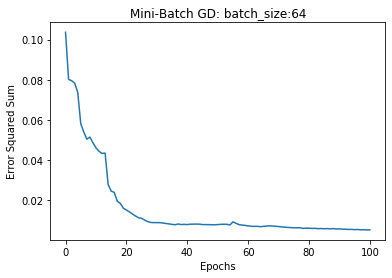

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Error Squared Sum')
plt.title('Mini-Batch GD: batch_size:{}'.format(nn.batch_size))
plt.show()

## 4. Overfitting: 

### 4.1 Increased Epochs

In [18]:
(X, y), (Xtest, ytest) = joy.load_mnist() 

X = X[:3000]
y = y[:3000]
epoch_list = [i for i in np.arange(5, 30, 5)] + [i for i in np.arange(50, 300, 30)]
self_accuracy = []
test_accuracy = []
for i, e in  enumerate(epoch_list):
    nn = MiniBatchGD(784, 100, 10, epochs = e, batch_size = 64)  
    nn.fit(X, y)  
    self_accuracy.append(nn.evaluate(X, y))  
    test_accuracy.append(nn.evaluate(Xtest, ytest))

Training epoch 0/5.
Training epoch 0/10.
Training epoch 10/10.
Training epoch 0/15.
Training epoch 10/15.
Training epoch 0/20.
Training epoch 10/20.
Training epoch 20/20.
Training epoch 0/25.
Training epoch 10/25.
Training epoch 20/25.
Training epoch 0/50.
Training epoch 10/50.
Training epoch 20/50.
Training epoch 30/50.
Training epoch 40/50.
Training epoch 50/50.
Training epoch 0/80.
Training epoch 10/80.
Training epoch 20/80.
Training epoch 30/80.
Training epoch 40/80.
Training epoch 50/80.
Training epoch 60/80.
Training epoch 70/80.
Training epoch 80/80.
Training epoch 0/110.
Training epoch 10/110.
Training epoch 20/110.
Training epoch 30/110.
Training epoch 40/110.
Training epoch 50/110.
Training epoch 60/110.
Training epoch 70/110.
Training epoch 80/110.
Training epoch 90/110.
Training epoch 100/110.
Training epoch 110/110.
Training epoch 0/140.
Training epoch 10/140.
Training epoch 20/140.
Training epoch 30/140.
Training epoch 40/140.
Training epoch 50/140.
Training epoch 60/140.

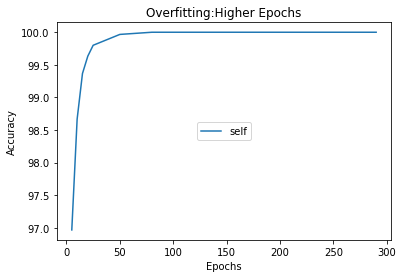

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.plot(epoch_list, self_accuracy, label='self')
#plt.plot(epoch_list, test_accuracy, label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Overfitting:Higher Epochs'.format(nn.batch_size))
plt.legend(loc='center')
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.plot(epoch_list, self_accuracy, label='self')
plt.plot(epoch_list, test_accuracy, label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Overfitting:Higher Epochs'.format(nn.batch_size))
plt.legend(loc='center')
plt.show()

### 4.2 Increased hidden neurons

In [ ]:
(X, y), (Xtest, ytest) = joy.load_mnist() 
n_h_list = np.linspace(50, 800, 16, dtype=int)

X = X[:3000]
y = y[:3000]
self_accuracy = []
test_accuracy = []
for n_h in  n_h_list:
    nn = MiniBatchGD(784, n_h, 10, epochs = 10, batch_size = 32)  
    nn.fit(X, y)  
    self_accuracy.append(nn.evaluate(X, y))  
    test_accuracy.append(nn.evaluate(Xtest, ytest))

In [ ]:
plt.plot(n_h_list, self_accuracy, label='self')
plt.plot(n_h_list, test_accuracy, label='test')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Accuracy')
plt.title('Overfitting:Higher Hidden Neurons')
plt.legend(loc='best')
plt.show()

## 5. MiniBatchGD_Dropout 클래스

In [11]:
class MiniBatchGD_Dropout(object): 
    """ Mini-batch Gradient Descent with Dropout """
    def __init__(self, n_x, n_h, n_y, eta=0.1, epochs=100, batch_size=32, random_seed=1, dropout_ratio=0.5):
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        self.batch_size = batch_size
        np.random.seed(random_seed)
        self.dropout_ratio = dropout_ratio
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1  # between -1 and 1
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1  # between -1 and 1
        #print('W1.shape={}, W2.shape={}'.format(self.W1.shape, self.W2.shape))
        
    def forpass(self, A0, train=True):
        Z1 = np.dot(self.W1, A0)                # hidden layer inputs
        A1 = self.g(Z1)                         # hidden layer outputs/activation func

        # Dropout
        if train:
            self.drop_units = np.random.rand(*A1.shape) > self.dropout_ratio
            A1 = A1 * self.drop_units / self.dropout_ratio
          
        Z2 = np.dot(self.W2, A1)                # output layer inputs
        A2 = self.g(Z2)                         # output layer outputs/activation func
        return Z1, A1, Z2, A2

    def fit(self, X, y):
        """ 
        X: input dataset 
        y: class labels
        """
        self.cost_ = []
        self.m_samples = len(y)       
        Y = joy.one_hot_encoding(y, self.n_y)       # (m, n_y) = (m, 10)   one-hot encoding
        #print('X.shape={}, y.shape={}, Y.shape={}'.format(X.shape, y.shape, Y.shape))
        
        for epoch in range(self.epochs + 1):
            if epoch % 100 == 0:
                print('Training epoch {}/{}.'.format(epoch, self.epochs))
            error = 0
            
            for i in range(0, self.m_samples, self.batch_size):
                A0 = X[i: i + self.batch_size].T
                Y0 = Y[i: i + self.batch_size].T
                Z1, A1, Z2, A2 = self.forpass(A0)        

                E2 = Y0 - A2                 
                E1 = np.dot(self.W2.T, E2)       

                # back prop, error prop
                dZ2 = E2 * self.g_prime(Z2)     
                dZ1 = E1 * self.g_prime(Z1)    

                # Dropout
                dZ1 = dZ1 * self.drop_units       

                # update weights
                self.W2 +=  self.eta * np.dot(dZ2, A1.T)     
                self.W1 +=  self.eta * np.dot(dZ1, A0.T)  
                error += np.sqrt(np.sum(E2 * E2))
            self.cost_.append(error/self.batch_size)
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z1, A1, Z2, A2 = self.forpass(A0, train=False)   # forpass
        return A2                                       

    def g(self, x):                             # activation_function: sigmoid
        return 1.0/(1.0+np.exp(-x))
    
    def g_prime(self, x):                    # activation_function: sigmoid derivative
        return self.g(x) * (1 - self.g(x))
    
    def evaluate(self, Xtest, ytest):       
        m_samples = len(ytest)
        scores = 0        
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

### 5.1 MiniBatchGD_Dropout  MNIST모델 만들기

In [15]:
import joy

(X, y), (Xtest, ytest) = joy.load_mnist()
m = 3000
X = X[:m]
y = y[:m]
nn = MiniBatchGD_Dropout(784, 600, 10, eta = 0.2, epochs = 10, dropout_ratio = 0.5)

nn.fit(X, y)
self = nn.evaluate(X, y)
test = nn.evaluate(Xtest, ytest)
print('MNIST self accuracy {}%'.format(self))
print('MNIST test accuracy {}%'.format(test))

Training epoch 0/10.
MNIST self accuracy 98.63333333333333%
MNIST test accuracy 92.12%


### 5.2 MiniBatchGD_Dropout  MNIST모델의 정확도

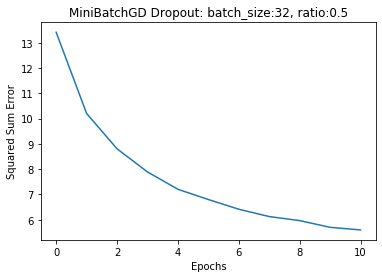

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum Error')
plt.title('MiniBatchGD Dropout: batch_size:{}, ratio:{}'.format(nn.batch_size, nn.dropout_ratio))
plt.show()

# Final Exam 
----------------------

## Accuracy of Each Digit

- get the histogram of each digit in the label `ytest`
- get the yhat of test dataset
- compare the output `yhat` and the label `ytest` to compute the accuracy 

In [ ]:
import joy
import numpy as np
(X, y), (Xtest, ytest) = joy.load_mnist()
nn = MiniBatchGD(784, 200, 10, epochs = 10)
nn.fit(X, y)
self_accuracy = nn.evaluate(X, y)
test_accuracy = nn.evaluate(Xtest, ytest)
print('Test accuracy {}%'.format(np.round(test_accuracy, 2)))

In [ ]:
histo = np.bincount(ytest)
print(histo)

In [ ]:
# Compute accuracy of each digit
A2 = nn.predict(Xtest)
yhat = np.argmax(A2, axis = 0)
truth = []
for i in np.arange(10):
    count = None (None for h, y in zip(yhat, ytest) if i == h == y)
    truth.append(count)
print('Digit Accuracy:', np.round(truth/histo, 2))
print('Total Accuracy:', np.round(sum(truth)/sum(histo), 2))

In [ ]:
# Compute accuracy of each digit
A2 = nn.predict(Xtest)
yhat = np.argmax(A2, axis = 0)
truth = []
for i in np.arange(10):
    count = sum(1 for h, y in zip(yhat, ytest) if i == h == y)
    truth.append(count)
print('Digit Accuracy:', np.round(truth/histo, 3))
print('Total Accuracy:', np.round(sum(truth)/sum(histo), 3))


print('Highest Accuracy:', np.argmax(truth/histo))
print('Lowest  Accuracy:', np.argmin(truth/histo))

In [ ]:
# to compute accuracy of each digit
A2 = nn.predict(Xtest)
yhat = np.argmax(A2, axis = 0)

truth = []
for i in np.arange(10):  # for each digit
    count = 0
    for hat, y in zip(yhat, ytest): 
        if i == hat == y: 
            count += 1
    truth.append(count)

print('Digit Accuracy:', np.round(truth/histo, 3))
print('Total Accuracy:', np.round(sum(truth)/sum(histo), 3))

## 학습 정리
- 미니배치$^{Mini-Batch}$ 경사하강법을 학습하기
- 학습 스케줄링
- 과대적합의 원인과 해결 방법
- 학습 조기 종료$^{early \ stopping}$
- 데디터 증식
- 드롭아웃$^{dropout}$

-------------------

_For God so loved the world that he gave his one and only Son, that whoever believes in him shall not perish but have eternal life. John3:16_